In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from wordpress_graph.paths import DATA_DIR
import feedparser
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [14]:
from wordpress_graph.xml_to_graph import post_info_from_xml, post_df_to_graph

In [15]:
xml_files = list(DATA_DIR.glob('xml/*.xml'))

In [16]:
post_df, tag_df = post_info_from_xml(xml_files)

['attachment' 'nav_menu_item' 'post']



['attachment' 'post']


In [17]:
display(post_df[:3])
len(post_df)

,title,tags,category,link,date,slug
0,Critical Behavior from Deep Dynamics: A Hidden...,"[Language, LSTM, Markov]",Papers,https://timsainburg.wordpress.com/2016/08/05/c...,"(2016, 8, 5, 2, 33, 37, 4, 218, 0)",critical_behavior_from_deep_dynamics:_a_hidden...
1,Adversarially Learned Inference,[GAN],Papers,https://timsainburg.wordpress.com/2016/08/05/a...,"(2016, 8, 5, 2, 58, 40, 4, 218, 0)",adversarially_learned_inference
2,InfoGAN: Interpretable Representation Learning...,[GAN],Papers,https://timsainburg.wordpress.com/2016/08/05/i...,"(2016, 8, 5, 3, 1, 20, 4, 218, 0)",infogan:_interpretable_representation_learning...


437

In [139]:
len(tag_df)

543

In [140]:
np.sum(tag_df.frequency)

1768

In [142]:
tag_df.sort_values(by="frequency", ascending=False).tag.values[:10]

array(['syntax', 'Birdsong', 'hierarchy', 'Language',
       'Language Acquisition', 'sequence learning', 'Recursion',
       'zebra finch', 'vocalization', 'Markov Models'], dtype=object)

,tag,frequency
487,syntax,78
10,Birdsong,64
267,hierarchy,59
51,Language,43
52,Language Acquisition,31
445,sequence learning,27
83,Recursion,25
541,zebra finch,24
524,vocalization,23
61,Markov Models,22


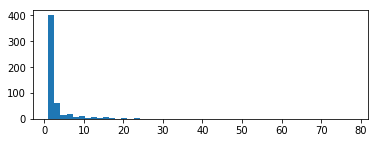

In [18]:
display(tag_df.sort_values(by="frequency", ascending=False)[:10])
fig, ax = plt.subplots(figsize=(6,2))
ax.hist(tag_df.frequency, bins=50);

In [145]:
len((tag_df[tag_df.frequency == 1]))/len(tag_df)

0.5893186003683242

### Make a graph
- the value of edges should be weighted by frequency of the overlapping tag

In [21]:
G, num_conns = post_df_to_graph(post_df, tag_df)
print(len(G.edges()), len(G.nodes()))


11753 420


,node,conns
345,experimental_evidence_for_compositional_syntax...,194
63,songbirds_possess_the_spontaneous_ability_to_d...,176
213,biological_foundations_and_origins_of_syntax,174
365,experimental_evidence_for_phonemic_contrasts_i...,173
104,songs_to_syntax:_the_linguistics_of_birdsong,173


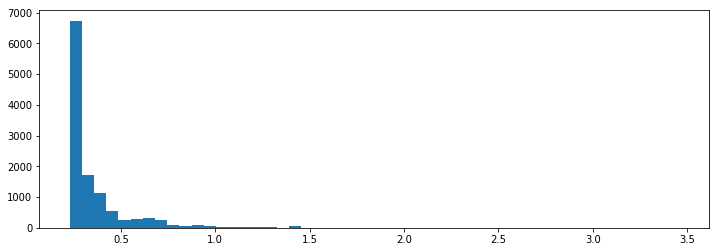

In [22]:
# show top connected posts
display(num_conns.sort_values(by="conns", ascending=False)[:5])
# take a look at the weight probabilities
weights = np.array([i['weight'] for i in list(G.edges().values())])
fig, ax = plt.subplots(ncols=1, figsize=(12,4))
ax.hist(weights, bins=50);

In [24]:
from wordpress_graph.paths import DATA_DIR

In [30]:
nx.write_gpickle(G, (DATA_DIR/"network_path.gpickle").as_posix())

### Cluster communiities

In [31]:
import community
import seaborn as sns

In [32]:
partition = community.best_partition(G)
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8}

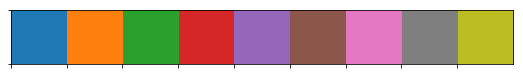

In [37]:
pal = sns.color_palette("tab10", n_colors=len(set(partition.values())))
sns.palplot(pal)

In [146]:

for count, com in enumerate(set(partition.values())):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    
    print(count)
    for node in list_nodes[:10]:
        print('\t' + node.replace('_', ' '))

0
	critical behavior from deep dynamics: a hidden dimension in natural language
	rule learning by seven-month-old infants
	a compact statistical model of the song syntax in bengalese finch
	information entropy of humpback whale songs
	simple rules can explain discrimination of putative recursive syntactic structures by a songbird species
	revisiting the syntactic abilities of non-human animals: natural vocalizations and artificial grammar learning
	songs to syntax: the linguistics of birdsong
	language evolution: semantic combinations in primate calls
	are there species-universal categories in bird song phonology and syntax? a comparative study of chaffinches (fringilla coelebs), zebra finches (taenopygia guttata), and swamp sparrows (melospiza georgiana)
	behavioral factors governing song complexity in bengalese finches
1
	adversarially learned inference
	infogan: interpretable representation learning by information maximizing generative adversarial nets
	improved techniques for train

### Get positions

In [52]:
spring_pos = nx.spring_layout(G, k=1/len(G.nodes())**.25)

In [101]:
kamada_kawai_pos = nx.drawing.layout.kamada_kawai_layout(G)

In [62]:
int(spring_pos['adversarially_learned_inference'][0]*256)

90

In [82]:
weights = []
for ui, (u, item) in enumerate(G.edges.items()):
    weights.append(item['weight'])

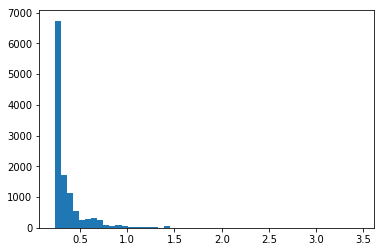

In [84]:
plt.hist(weights, bins = 50);

In [137]:
nodes = [
    {
        "id": str(i),
        "label": str(i).replace('_', " "),
        "group": partition[i],
        "color": "rgba("
        + ",".join([str(int(i * 255)) for i in pal[partition[i]]])
        + ")",
        "x": int(kamada_kawai_pos[i][0] * 256),
        "y": int(kamada_kawai_pos[i][1] * 256),
        "size": 1,
        "type": "goo"
    }
    for ni, i in enumerate(G.nodes())
]
links = [
    {
        "id": str(ui),
        "source": u[0],
        "target": u[1],
        "color": "rgba(0,0,0," + str(round(np.min([item["weight"], 1])/5, 2)) + ")",
    }
    for ui, (u, item) in enumerate(G.edges.items())
]

graph_data = {"nodes": nodes, "edges": links}

In [138]:
with open(DATA_DIR/'post_data.json', 'w') as f:
    json.dump(graph_data,
              f, indent=4,)